Do you want fix all or and specific data cube?("all" or "s") s
Introduce ID: 699
Enter x[pix]: 80
Enter y[pix]: 80
Enter sma[pix] 5
Enter eps: 0.1
Enter PA[deg] 120


<IPython.core.display.Javascript object>


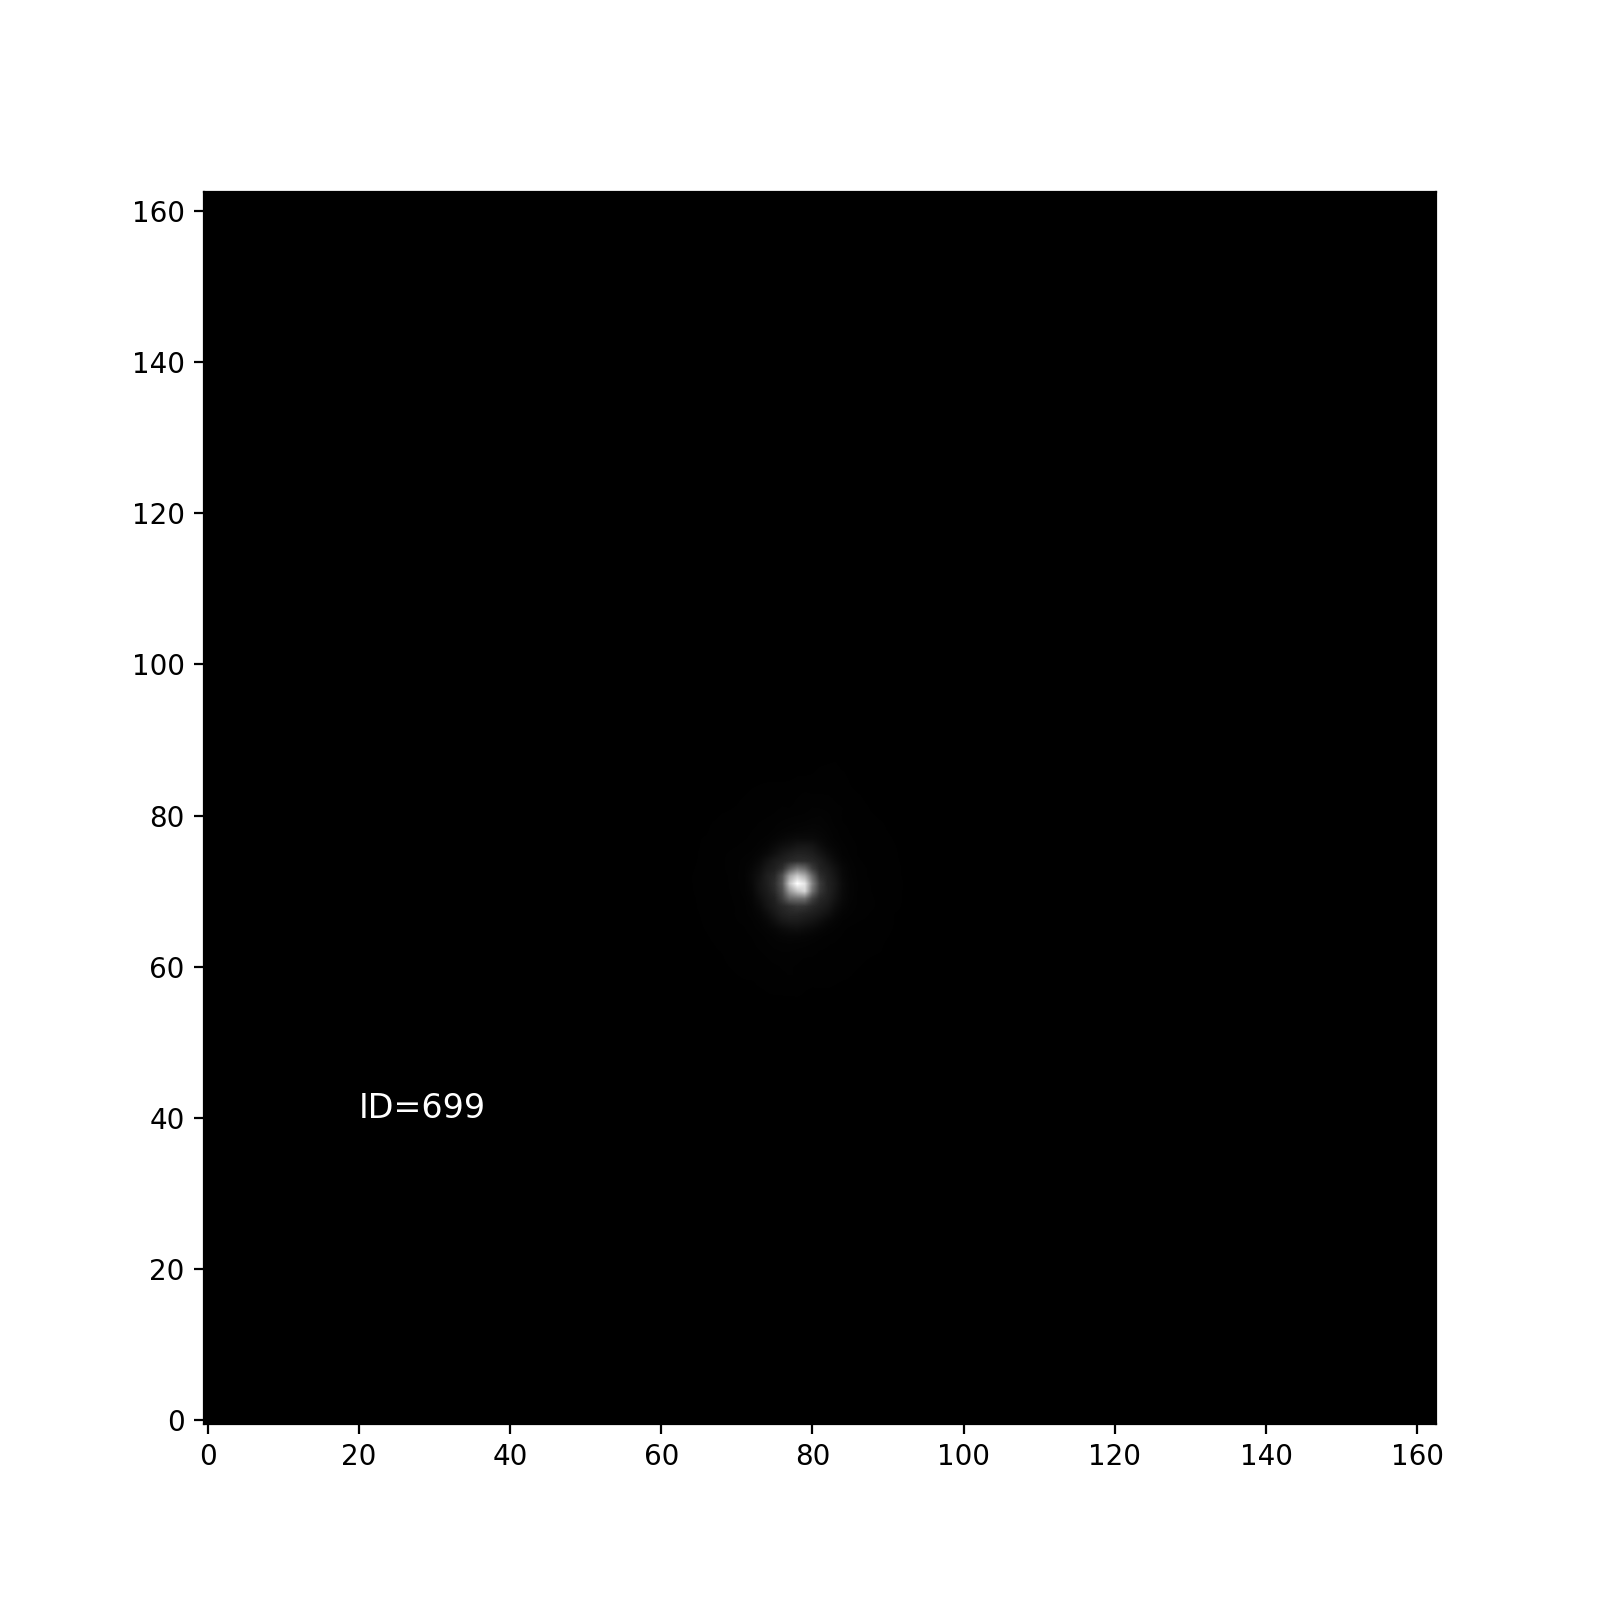

Do you want to repeat the isophotal fitting? ("y" or "n"): y
Repeting the fitting for ID=699.
Enter x[pix]: 80
Enter y[pix]: 80
Enter sma[pix] 10
Enter eps: 0.2
Enter PA[deg] 90


<IPython.core.display.Javascript object>


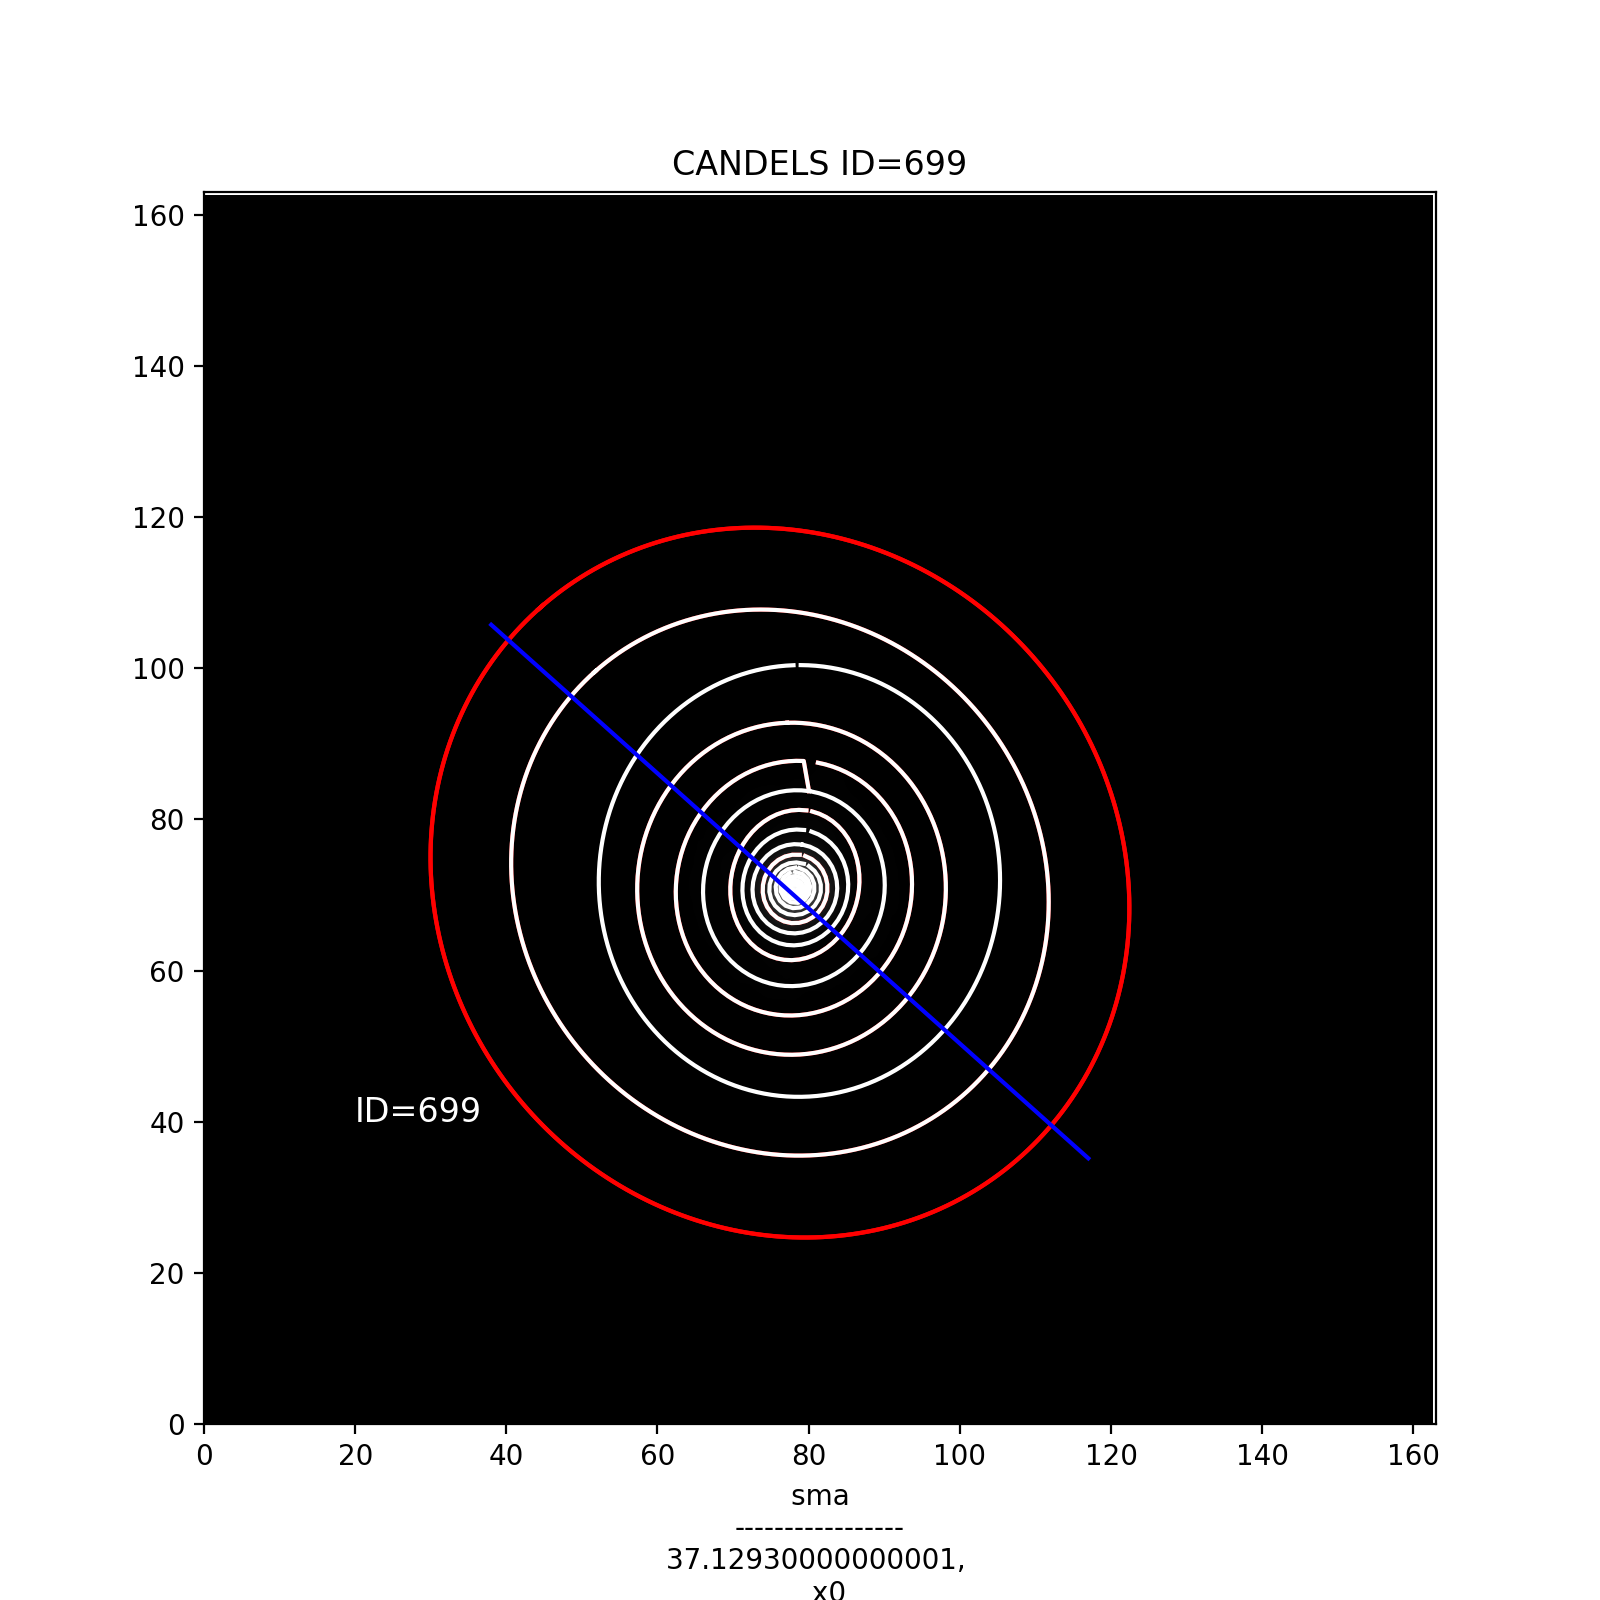

Do you want to repeat the isophotal fitting? ("y" or "n"): n
Isophotal fitting for ID=699 is done.


In [30]:
from matplotlib import patches
from astropy.io import fits
import numpy as np
import math
import matplotlib.pyplot as plt 
from astropy.io import ascii 
from astropy.table import Table, Column
from astropy import units as u  
from matplotlib import cm
import glob
from astropy.cosmology import FlatLambdaCDM
import regions
from regions import PixCoord
from astropy.wcs import WCS
from astropy import wcs
from astropy.wcs import utils
from astropy.coordinates import SkyCoord
import os.path
from skimage.feature import peak_local_max
import scipy.ndimage as ndimage
import scipy.ndimage.filters as filters
from astropy.io import fits
from photutils.isophote import EllipseGeometry
from photutils.isophote import Ellipse
from photutils.isophote import EllipseSample, EllipseFitter
from astropy.stats import SigmaClip, sigma_clipped_stats
import sewpy
import math
from photutils.background import Background2D, MedianBackground
from scipy import stats

import matplotlib.image as img

path_fits= '/home/gonzalez/sci/CANDELS'
hdul = fits.open('{0}/central-galaxies-full.fits'.format(path_fits))
cat= Table.read(hdul[1])
z = cat['zphot']
ID_cat=cat['Seq']
inst= 'CANDELS'

def ellipse_fit(ID, x0,y0,sma,eps,pa):
    
    geometry = EllipseGeometry(x0=x0, y0=y0, sma=sma, eps=eps, pa=pa * np.pi / 180.)
    
    file_hst = '{0}/{1}-{2}/HST-{2}/{1}_{2}-f850lp_v2.0_sci-15kpc.fits'.format(path_fits,inst, ID)
    hdu = fits.open(file_hst)
    hst_image=hdu[0].data
    
    #Ellipse isophote
    ellipse = Ellipse(hst_image, geometry)
    isolist = ellipse.fit_image(step=0.3)
    table= isolist.to_table()
    
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(hst_image,origin='lower', cmap=cm.gray, interpolation='bilinear')
    ax.annotate('ID={0}'.format(ID), (20,40 ), xytext= (20, 40),  size=12, color='w')
    isos = []
    if len(isolist.sma)>>0:
        for sma in [5., 10., 15., 25., 35., 45., 50.]:
            iso = isolist.get_closest(sma)
            isos.append(iso)
            x, y, = iso.sampled_coordinates()
            plt.plot(x, y, color='r')
        plt.title('{0} ID={1}'.format(inst,ID))
        table.write('{0}/{1}-{2}/photometry-{2}.fits'.format(path_fits, inst, ID),format='ascii', overwrite=True)
        pa= table['pa']/u.deg
        inx= len(pa)-1
        x_center= int(table[2]['x0'])
        y_center= int(table[2]['y0'])
        x0=table['x0']
        y0=table['y0']
        sma=table['sma']
        intens= table['intens'] 
        
        #to plot the last isophote
        for i in range(len(sma)):
            if intens[i]>= 2*back:    
                iso2 = isolist.get_closest(sma[i])
                x_last, y_last, = iso2.sampled_coordinates()
                plt.plot(x_last, y_last, color='w')
                table2=iso2.to_table()
        pa_out= table2['pa']/u.deg
        pa_err= table2['pa_err']/u.deg
        x0_out=table2['x0']
        y0_out=table2['y0']
        sma_out=table2['sma']
        intens_out= table2['intens']
        ellip= table2['ellipticity']
        #save the last isophote
        last_isophote= Table()
        last_isophote.add_column(x0_out, name='x0')
        last_isophote.add_column(y0_out, name='y0')
        last_isophote.add_column(x_center, name='x_center')
        last_isophote.add_column(y_center, name='y_center')
        last_isophote.add_column(sma_out, name='sma')
        last_isophote.add_column(ellip, name='ellipticity')
        last_isophote.add_column(intens_out, name='intens')
        last_isophote.add_column(pa_out, name='pa')
        last_isophote.add_column(pa_err, name='pa_err')
        last_isophote.write('{0}/{1}-{2}/out-isophote-{2}.fits'.format(path_fits,inst, ID), format= 'fits', overwrite=True) 
                   
        if pa_out>90: 
            x_recta = np.array(range(x_center-40,x_center+40))
            y_recta= (((pa_out-180)*np.pi / 180)*(x_recta- x_center))+y_center
            plt.plot(x_recta, y_recta, 'b')
            plt.xlim(0,len(hst_image))
            plt.ylim(0,len(hst_image))
            plt.xlabel('{0}, \n {1} \n {2} \n {3} \n PA={4}, BACKGROUND={5}'.format(sma_out, x0_out, y0_out, ellip,pa_out, back))
            plt.show()
                      
        elif pa_out<90: 
            x_recta = np.array(range(x_center-40,x_center+40))
            y_recta= (((pa_out)*np.pi / 180)*(x_recta- x_center))+y_center
    
            plt.plot(x_recta, y_recta, 'b')
            plt.xlim(0,len(hst_image))
            plt.ylim(0,len(hst_image))
            plt.xlabel('{0}, {1},{2}, {3} \n PA={4}, BACKGROUND={5}'.format(sma_out, x0_out, y0_out, ellip, pa_out, back))
            plt.title('ID={0}'.format(ID))
            plt.show()

    
def background():
    global back, bkg
    file_hst = '{0}/{1}-{2}/HST-{2}/{1}_{2}-f850lp_v2.0_sci-15kpc.fits'.format(path_fits,inst, ID)
    hdu = fits.open(file_hst)
    data=hdu[0].data
    #to calculate teh BKG
    sigma_clip = SigmaClip(sigma=3.0)
    bkg_estimator = MedianBackground()
    bkg = Background2D(data, (20, 20), filter_size=(3, 3),
                   sigma_clip=sigma_clip, bkg_estimator=bkg_estimator)#exclude_percentile=0
    back= bkg.background_median

    
which= input('Do you want fix all or and specific data cube?("all" or "s") ')
if which=='all':
    old= input('Do you want to plot a previous fitting? ("y" or "n") ')
    if old=='n':
        #def params
        x0,y0,sma,eps,pa= 100,100,50,0.5,90
        for m in range(len(z)):
            ID= ID_cat[m]
            file_exists=os.path.exists('{0}/{1}-{2}'.format(path_fits,inst, ID))
            file_exists2=os.path.exists('{0}/{1}-{2}/out-isophote-{2}.fits'.format(path_fits,inst, ID))
                
            if file_exists==True:
                if file_exists2==False:
                    print('Doing for ID={0}'.format(ID))
                    background()
                    ellipse_fit(ID, x0,y0,sma,eps,pa)
                    
                    
                elif file_exists2==True:
                    os.remove('{0}/{1}-{2}/out-isophote-{2}.fits'.format(path_fits,inst, ID))
                    print('Isophotal fitting is done for ID={0}.'.format(ID))
    elif old=='y':
        for m in range(len(z)):
            ID= ID_cat[m]
            file_exists2=os.path.exists('{0}/{1}-{2}/out-isophote-{2}.fits'.format(path_fits,inst, ID))
            if file_exists2==False:
                print('Previous fitting does not exits!')
           
            elif file_exists==True:
                background()
                file_hst = '{0}/{1}-{2}/HST-{2}/{1}_{2}-f850lp_v2.0_sci-15kpc.fits'.format(path_fits,inst, ID)
                hdu = fits.open(file_hst)
                hst_image=hdu[0].data
                table_old= Table.read('{0}/{1}-{2}/out-isophote-{2}.fits'.format(path_fits,inst, ID),  format= 'fits')
                pa_old= table_old['pa']
                x0_old=table_old['x0']
                y0_old=table_old['y0']
                x_center=int(table_old['x_center'])
                y_center=int(table_old['y_center'])
                sma_old=table_old['sma']
                smb_old= sma_old-sma_old*table_old['ellipticity']
                ellip= table_old['eps']
                fig, ax = plt.subplots(figsize=(8, 8))
                ax.imshow(hst_image,origin='lower', cmap=cm.gray, interpolation='bilinear')
                e_old = patches.Ellipse((x0_old, y0_old), width=2*sma_old,height=2*smb_old, angle=pa_old,color='white', linewidth=2, fill=False, zorder=2)
                ax.add_patch(e_old)
               
                if pa_old>90: 
                    x_recta = np.array(range(x_center-40,x_center+40))
                    y_recta= (((pa_old)*np.pi / 180)*(x_recta- x_center))+y_center
                        
                    ax.plot(x_recta, y_recta, 'b')
                    plt.xlim(0,len(hst_image))
                    plt.ylim(0,len(hst_image))
                    plt.xlabel('{0}, \n {1} \n {2} \n {3} \n {4}, BACKGROUND={5}'.format(sma_old, x0_old, y0_old, ellip,pa_old, back))
                    plt.show()
                      
                elif pa_old<90: 
                    x_recta = np.array(range(x_center-40,x_center+40))
                    y_recta= (((pa_old)*np.pi / 180)*(x_recta- x_center))+y_center
                    ax.plot(x_recta, y_recta, 'b')
                    plt.xlim(0,len(hst_image))
                    plt.ylim(0,len(hst_image))
                    plt.xlabel('{0}, \n {1} \n {2} \n {3} \n {4}, BACKGROUND={5}'.format(sma_old, x0_old, y0_old, ellip,pa_old, back))
                    plt.title('ID={0}'.format(ID))
                    plt.show()
                
    
elif which=='s':
    ID= int(input('Introduce ID: '))
    file_exists=os.path.exists('{0}/{1}-{2}'.format(path_fits,inst, ID))
    if file_exists==True:
         while True:
            #Ellipse isophote
            x0= int(input('Enter x[pix]: '))
            y0= int(input('Enter y[pix]: '))
            sma= int(input('Enter sma[pix] '))
            eps= float(input('Enter eps: '))
            pa= float(input('Enter PA[deg] '))
          #  x0,y0,sma,eps,pa= 60,60,30,0.3,90

            background()
            ellipse_fit(ID, x0,y0,sma,eps,pa)    
            
            check = input('Do you want to repeat the isophotal fitting? ("y" or "n"): ')
            
            if check=='n':
                print('Isophotal fitting for ID={0} is done.'.format(ID))
                break
                
            elif check=='y':
                print('Repeting the fitting for ID={0}.'.format(ID))
                continue

Do you want fix all or and specific data cube?("all" or "s")s
Introduce ID: 699
[4.551661356395083]
[4.551661356395083]


<IPython.core.display.Javascript object>


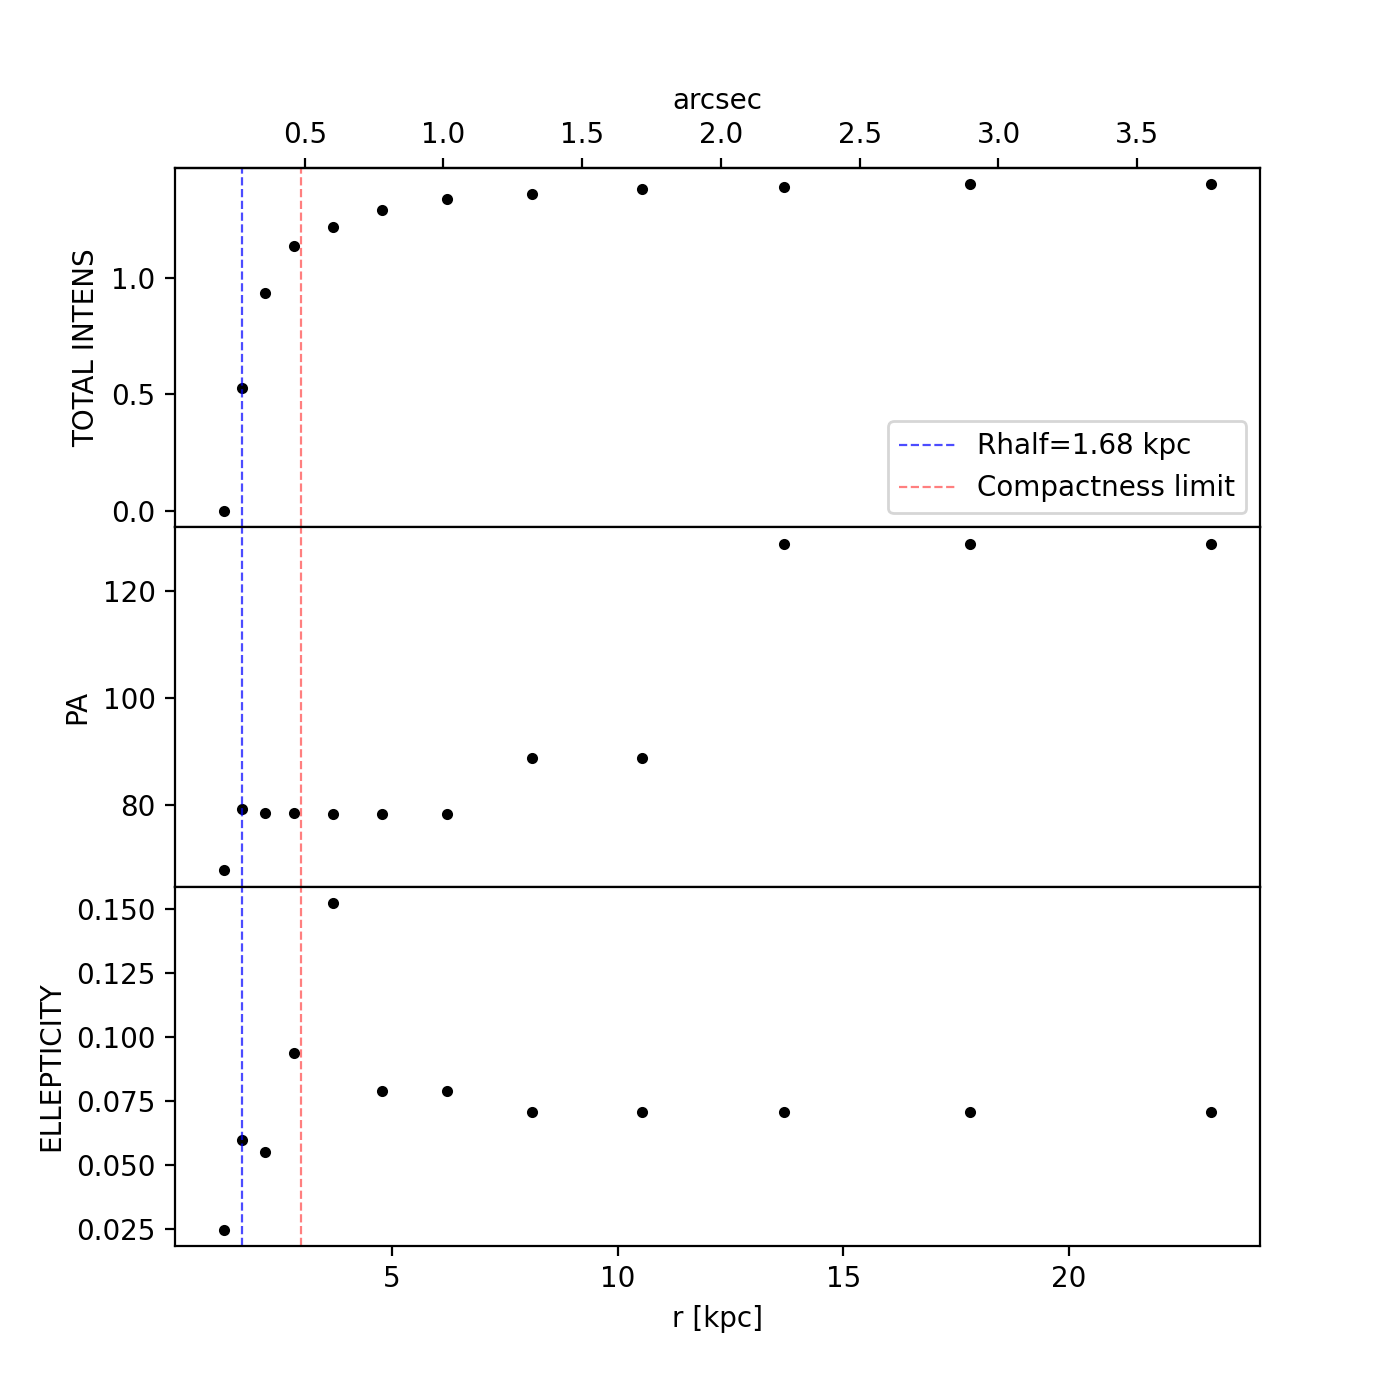

<IPython.core.display.Javascript object>


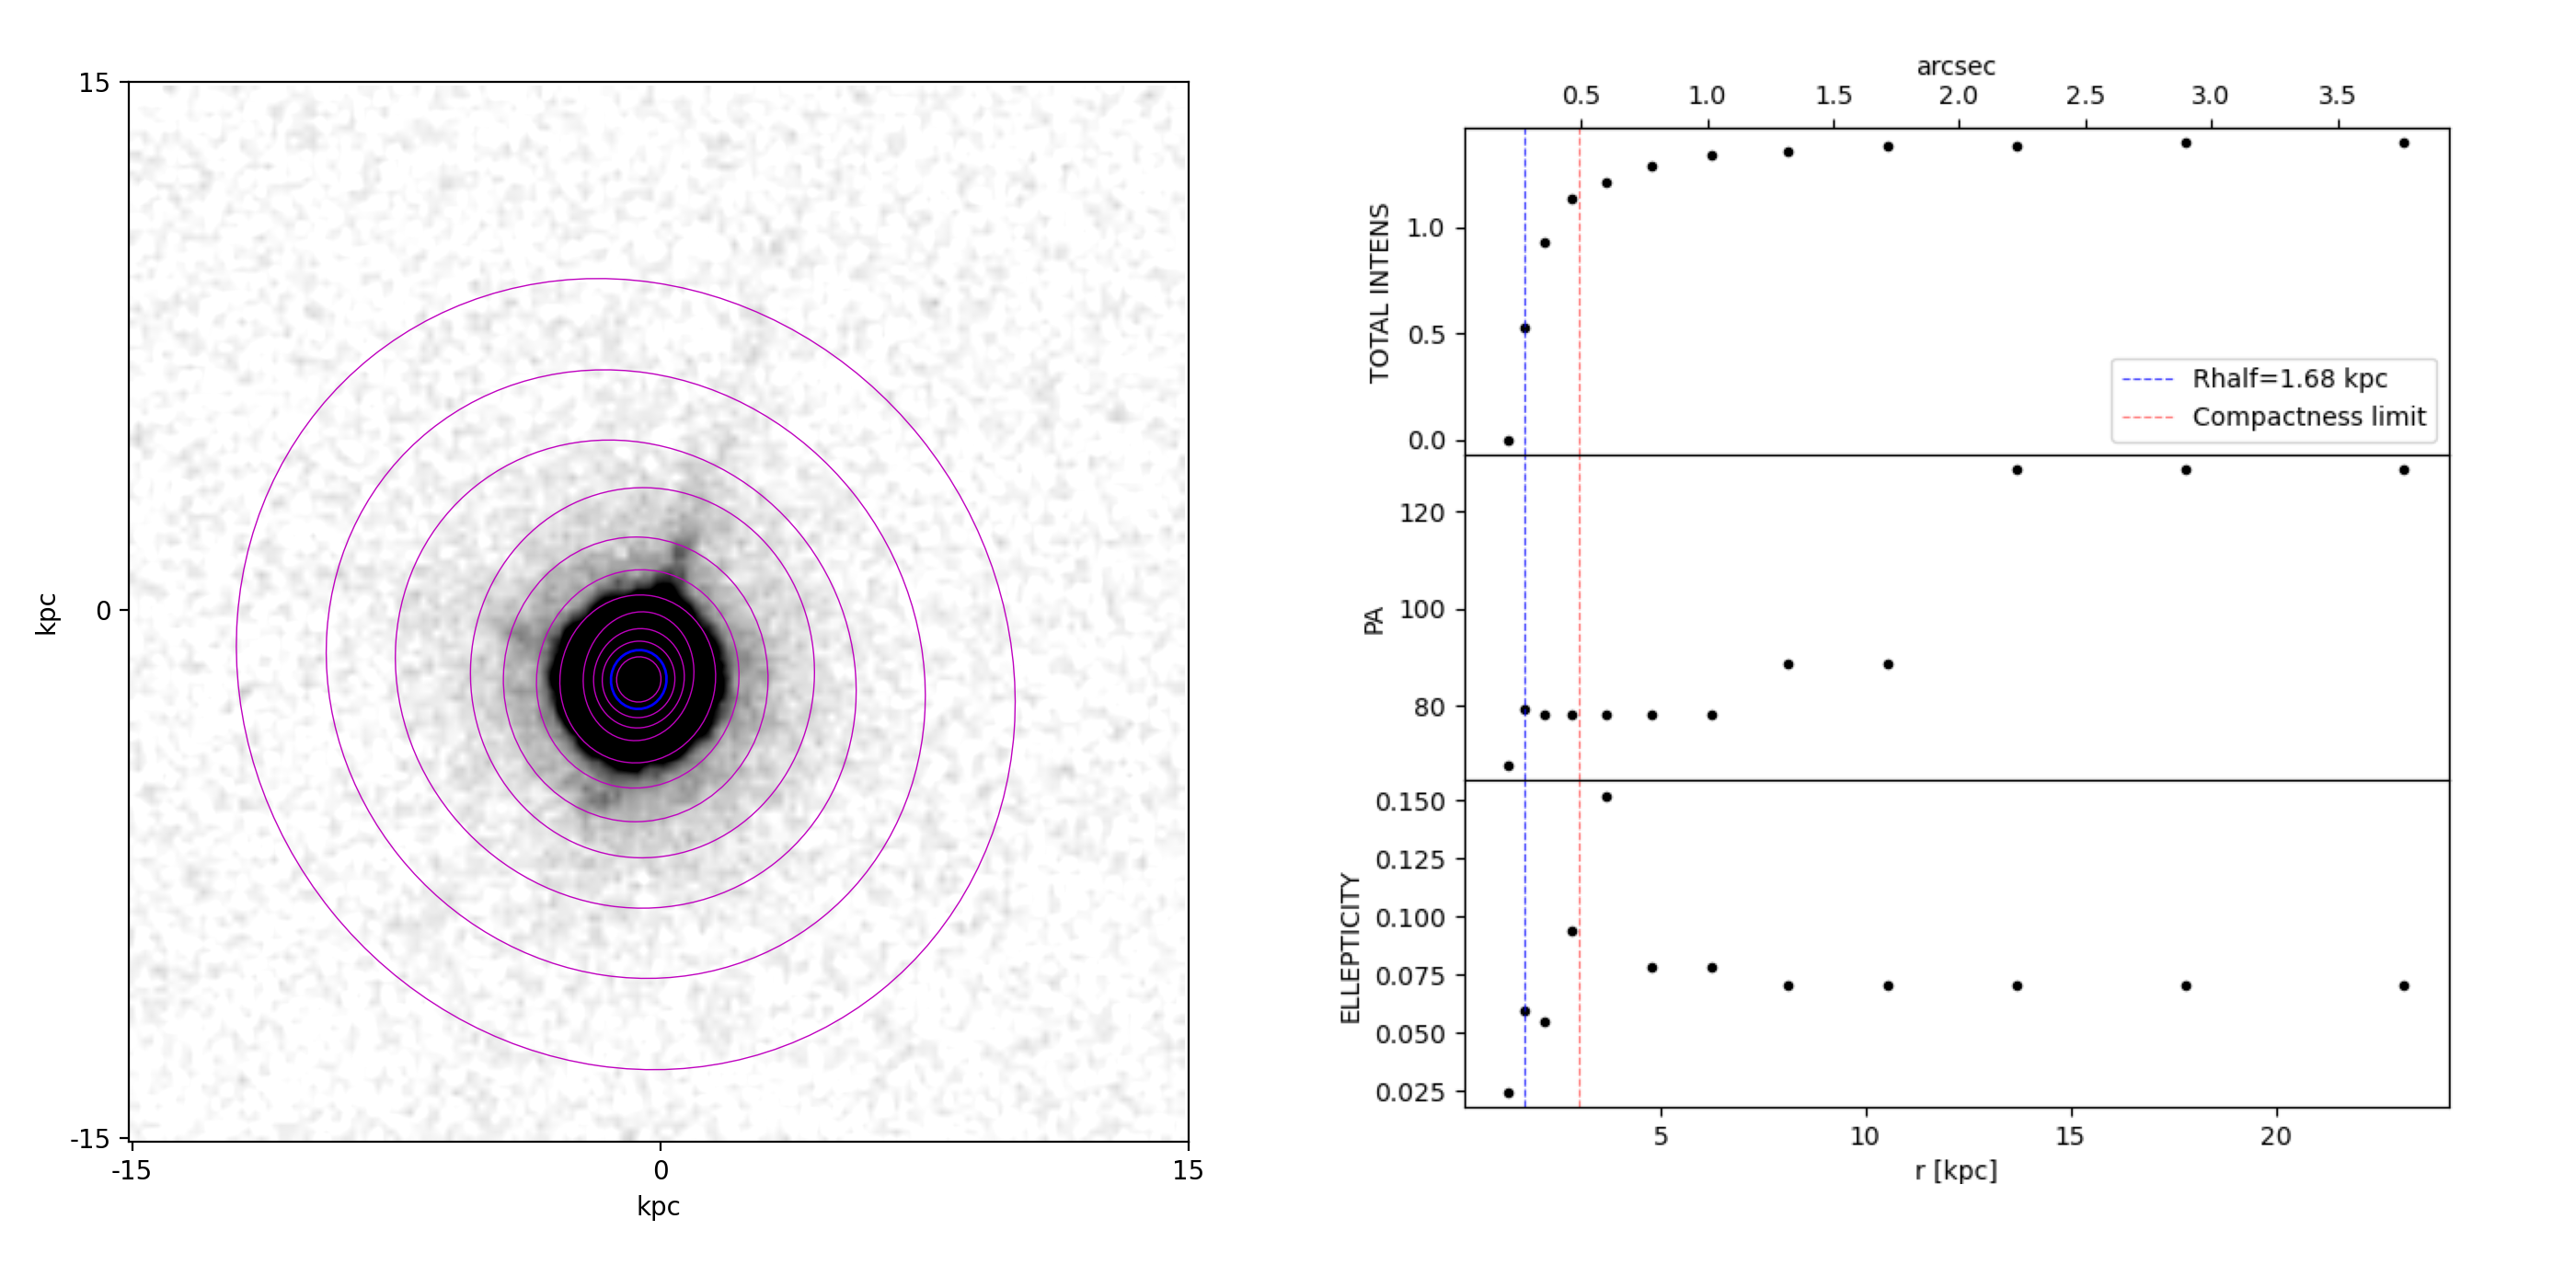

DONE


In [33]:
from matplotlib import patches
from astropy.io import fits
import numpy as np
import math
import matplotlib.pyplot as plt 
from astropy.io import ascii 
from astropy.table import Table, Column
from astropy import units as u  
from matplotlib import cm
import glob
from astropy.cosmology import FlatLambdaCDM
import regions
from regions import PixCoord, EllipsePixelRegion
from astropy.wcs import WCS
from astropy import wcs
from astropy.wcs import utils
from astropy.coordinates import SkyCoord
import os.path
from skimage.feature import peak_local_max
import scipy.ndimage as ndimage
import scipy.ndimage.filters as filters
from photutils.isophote import EllipseGeometry
from photutils.isophote import Ellipse
from photutils.isophote import EllipseSample, EllipseFitter
import sewpy
from scipy import integrate
import matplotlib.image as img


path_fits= '/home/gonzalez/sci/CANDELS'
hdul = fits.open('{0}/central-galaxies-full.fits'.format(path_fits))
cat= Table.read(hdul[1])
z_cat = cat['zphot']
ID_cat= cat['Seq']
inst= 'CANDELS'

cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

%matplotlib notebook

def pix_to_kpc(pix):
    global r, DA
    #conver pixels to plate scale
    hst_pixelscale = u.pixel_scale(0.030*u.arcsec/u.pixel)
    con = (pix*u.pixel).to(u.arcsec, hst_pixelscale)  
    #conver arcsec to radians
    rad = con*(4.85*(10**(-6)))/u.arcsec
    DA = cosmo.angular_diameter_distance(z=z)
    #DA=  1610800 #Kpc
    #diametro angular a kpc 
    r= (rad*DA*1000)*2
    return r

def kpc(r_kpc):
    return r_kpc*1

def kpc_to_pix(r_kpc):
     return r_kpc/((4.85*(10**(-6))) *DA*1000/u.Mpc)

    

def R50(Itotal,x, I):
        global yvar, xvar, Inte_var, dif, R50_kpc , R50_pix 
        yvar= []
        xvar=[]
        Inte_var=[]
        dif=[]
      
        for i in range(len(x)):
            yvar.append(I[i])
            xvar.append(x[i])
            Ivar= integrate.simps(yvar, x=xvar)
            d= abs(Ivar-(Itotal/2))
            dif.append(d)
            Inte_var.append(Ivar)
        
    
        dif_min= np.min(dif)
        
        R50_pix=[]
        for j in range(len(xvar)):
            if dif[j]== dif_min:
                R50_pix.append(xvar[j])
        
        print (R50_pix)
        #to conver R50 pix in kpc
        pix=R50_pix
        pix_to_kpc(pix)
        R50_kpc=r/u.Mpc      

def reff(ID):
    global Itotal, x, I
    #read PA_phot
    file_existsPHOT=os.path.exists('{0}/{1}-{2}/out-isophote-{2}.fits'.format(path_fits,inst, ID))
    if file_existsPHOT==True:
        table_iso= Table.read('{0}/{1}-{2}/photometry-{2}.fits'.format(path_fits, inst, ID), format= 'ascii')
        I= table_iso['intens']
        x= table_iso['sma']
        xc=table_iso['x0']
        yc=table_iso['y0']
        pa= table_iso['pa']
        ellip=table_iso['ellipticity']
        x_good=[]
        I_good=[]
        pa_good=[]
        xc_good=[]
        yc_good=[]
        ellip_good=[]
        B=[]
        
        for i in range(len(x)):
            if x[i]>3.1: # PSF of 0.125 arcsec from Giavalisco et al. 2004
                x_good.append(x[i])
                I_good.append(I[i])
                pa_good.append(pa[i])
                xc_good.append(xc[i])
                yc_good.append(yc[i])
                ellip_good.append(ellip[i])
       
        for i in range(len(ellip_good)):
            b= x_good[i] - (ellip_good[i]*x_good[i])
            B.append(b)
    
        table_out= Table.read('{0}/{1}-{2}/out-isophote-{2}.fits'.format(path_fits,inst, ID),  format= 'fits')
        sma_out=table_out['sma']
        intens_out=table_out['intens']
        
        #to convert sma pix in kpc
        pix=x_good
        pix_to_kpc(pix)
        r_kpc=r/u.Mpc
        
        pix=2.1
        pix_to_kpc(pix)
        psf_kpc=r/u.Mpc
        
        #Integration
        Itotal= integrate.simps(I_good, x=x_good)
    
        R50(Itotal, x_good, I_good)
    
        print (R50_pix)
   #     #-----plot-----
        fig, (ax1,ax2,ax3) = plt.subplots(3,1, sharex=True, gridspec_kw={'hspace': 0}, figsize=(7, 7))
       # plt.rc('text', usetex=True)     
        #----------plot intens---------------
        ax1.plot(r_kpc,Inte_var, 'k.')
        #plt.gca().invert_yaxis()
        ax1.axvline(x=R50_kpc, linewidth=0.8, color='b', linestyle ='--', alpha=0.7, label='Rhalf={0} kpc'.format("%.2f" % R50_kpc))
        #ax1.annotate('Rhalf={0} kpc'.format("%.2f" % R50_kpc), (R50_kpc, np.max(I)), xytext= (R50_kpc +0.1, np.max(I)), color='k')
        ax1.axvline(x=3, linewidth=0.8, color='r', linestyle ='--', alpha=0.5, label= 'Compactness limit')
        arc = ax1.secondary_xaxis('top', functions=(kpc_to_pix, kpc))
        arc.set_xlabel('arcsec')
        ax1.set_ylabel('TOTAL INTENS')
        ax1.legend()

        ax2.plot(r_kpc,pa_good, 'k.')
        ax2.axvline(x=R50_kpc, linewidth=0.8, color='b', linestyle ='--', alpha=0.7)
        ax2.axvline(x=3, linewidth=0.8, color='r', linestyle ='--', alpha=0.5, label= 'Compactness limit')
        ax2.set_ylabel('PA')
              
        ax3.plot(r_kpc,ellip_good, 'k.')
        ax3.axvline(x=R50_kpc, linewidth=0.8, color='b', linestyle ='--', alpha=0.7)
        ax3.axvline(x=3, linewidth=0.8, color='r', linestyle ='--', alpha=0.5)
        ax3.set_ylabel('ELLEPTICITY')   
        ax3.set_xlabel('r [kpc]')
        plt.savefig('{0}/{1}-draw/{1}-HST-{2}-elliparameters.png'.format(path_fits,inst,ID))
        
        
             #-----plot-----
        fig, (ax1,ax2) = plt.subplots(1,2,gridspec_kw={'width_ratios': [1, 1.2]}, figsize=(14,7))
        #---------------plot isophotes-------------
        file_hst = '{0}/{1}-{2}/HST-{2}/{1}_{2}-f850lp_v2.0_sci-15kpc.fits'.format(path_fits,inst, ID)
        hdu = fits.open(file_hst)
        hst_image=hdu[0].data
        ax1.imshow(hst_image, origin='lower', vmax = 0.015 ,vmin = 0, cmap=cm.gist_yarg, interpolation='bilinear')
           
        for i in range(len(x_good)):
            ellipse_pix = EllipsePixelRegion(center=PixCoord(x=xc_good[i], y=yc_good[i]),height= B[i]*2 , width= x_good[i]*2, angle=(pa_good[i])* u.deg)
            if x_good[i]== R50_pix:
                artist = ellipse_pix.as_artist(facecolor='none', edgecolor='b', linewidth= 1)
                ax1.add_artist(artist)
            else: 
                artist = ellipse_pix.as_artist(facecolor='none', edgecolor='m', linewidth= 0.5)
                ax1.add_artist(artist)
                
            
        #axis to kpc
        kpc_axis= ['-15','0', '15']# size 50kpc
        c= (len(hst_image))/2
        x_kpc= [0, c, len(hst_image)] 
        ax1.set_xticks(x_kpc) # values
        ax1.set_xticklabels(kpc_axis, size=10) # labels
        ax1.set_yticks(x_kpc) # values
        ax1.set_yticklabels(kpc_axis, size=10)
        ax1.set_xlabel('kpc', size=10)
        ax1.set_ylabel('kpc', size=10)
    
        #----------parameters________
        params = img.imread('{0}/{1}-draw/{1}-HST-{2}-elliparameters.png'.format(path_fits,inst,ID))
        ax2.imshow(params)
        ax2.axis('off')
        ax2.set_ylim(len(params)-35, 35)
        plt.subplots_adjust(left=0.05,
                        bottom=0.05, 
                        right=1, 
                        top=1, 
                        wspace=0.1,
                        hspace=-0.3)
        plt.savefig('{0}/{1}-draw/{1}-HST-{2}-phot.png'.format(path_fits,inst,ID))
        os.remove('{0}/{1}-draw/{1}-HST-{2}-elliparameters.png'.format(path_fits,inst,ID))
    else:
        print ('No')

which= input('Do you want fix all or and specific data cube?("all" or "s")')
global ID, z
global slope, pa_kim

if which=='all':
    for m in range(len(z_cat)):
        ID= ID_cat[m]
        z= z_cat[m]
        reff(ID)
    
                
elif which=='s':
    ID=int(input('Introduce ID: '))
    z=[]
    for m in range(len(z_cat)):
        if ID==ID_cat[m]:
            z.append(z_cat[m])
            reff(ID)
            print('DONE')

In [26]:
from matplotlib import patches
from astropy.io import fits
import numpy as np
import math
import matplotlib.pyplot as plt 
from astropy.io import ascii 
from astropy.table import Table, Column
from astropy import units as u  
from matplotlib import cm
import glob
from astropy.cosmology import FlatLambdaCDM
import regions
from regions import PixCoord, EllipsePixelRegion
from astropy.wcs import WCS
from astropy import wcs
from astropy.wcs import utils
from astropy.coordinates import SkyCoord
import os.path
from skimage.feature import peak_local_max
import scipy.ndimage as ndimage
import scipy.ndimage.filters as filters
from photutils.isophote import EllipseGeometry
from photutils.isophote import Ellipse
from photutils.isophote import EllipseSample, EllipseFitter
import sewpy
from scipy import integrate
import matplotlib.image as img
from astropy.table import join

path_fits= '/home/gonzalez/sci/CANDELS'
cat= Table.read('/home/gonzalez/sci/CANDELS/central-galaxies-full.fits')
z_cat = cat['zphot']
ID_cat=cat['Seq']
r50=cat['FLUX_RADIUS_2_F850LP']
inst= 'CANDELS'
morpho=cat['Morpho']

cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

def pix_to_kpc(pix):
    global r, DA
    #conver pixels to plate scale
    hst_pixelscale = u.pixel_scale(0.030*u.arcsec/u.pixel)
    con = (pix*u.pixel).to(u.arcsec, hst_pixelscale)  
    #conver arcsec to radians
    rad = con*(4.85*(10**(-6)))/u.arcsec
    DA = cosmo.angular_diameter_distance(z=z_cat)
    #DA=  1610800 #Kpc
    #diametro angular a kpc 
    r= (rad*DA*1000)*2
    return r

def kpc(r_kpc):
    return r_kpc*1

def kpc_to_pix(r_kpc):
     return r_kpc/((4.85*(10**(-6))) *DA*1000/u.Mpc)


pix_to_kpc(r50)
r_kpc=r/u.Mpc

compact=[]
for i in range(len(cat)):
   # print('ID:{0}, R50:{1}'.format(ID_cat[i],"%.2f" %  r_kpc[i]))
    if r_kpc[i]<=3.0:
        compact.append(r_kpc)
        cat['Morpho'][i] = -2
       # print(cat['Morpho'][i])

cat.write('/home/gonzalez/sci/CANDELS/central-galaxies-full.fits', format= 'fits', overwrite=True)

            
print(len(compact))

104
